# **DEEP LEARNING**
## **LAB 12**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.models import vgg16
from torch.nn.functional import interpolate
from PIL import Image

In [5]:
# Define custom collate function to resize and convert PIL images to tensors
def custom_collate(batch):
    images, masks = zip(*batch)
    images = [transforms.Resize((224, 224))(img) for img in images]
    images = [transforms.ToTensor()(img) for img in images]
    masks = [transforms.Resize((224, 224))(mask) for mask in masks]
    masks = [transforms.ToTensor()(mask)[0, :, :] for mask in masks]  # Take the first channel (assuming single-channel masks)
    return torch.stack(images), torch.stack(masks)

# Define SegNet architecture with modified decoder for spatial size matching
class SegNet(nn.Module):
    def __init__(self, num_classes):
        super(SegNet, self).__init__()

        # Encoder (VGG16)
        self.encoder = vgg16(pretrained=True).features
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, num_classes, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)  # Upsample to match original image size
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [6]:
# Hyperparameters
batch_size = 16
num_epochs = 5
learning_rate = 0.001

# Download and preprocess Pascal VOC dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform)
val_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=custom_collate)



100%|██████████| 1999639040/1999639040 [01:36<00:00, 20694007.56it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [7]:
# Initialize model
model = SegNet(num_classes=21)  # Pascal VOC has 21 classes

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 168MB/s]  


In [12]:
import matplotlib.pyplot as plt

# Lists to store training and validation loss, accuracy
train_losses = []
val_losses = []
accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_pixels = 0
    total_pixels = 0
    for images, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        outputs = interpolate(outputs, size=(224, 224), mode='bilinear', align_corners=True)  # Ensure output size matches target
        loss = criterion(outputs, masks.long())  # Convert masks to long type
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_pixels += (predicted == masks).sum().item()
        total_pixels += masks.numel()
    
    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_pixels / total_pixels
    accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        for images, masks in val_loader:
            outputs = model(images)
            outputs = interpolate(outputs, size=(224, 224), mode='bilinear', align_corners=True)  # Ensure output size matches target
            val_loss += criterion(outputs, masks.long())  # Convert masks to long type
            _, predicted = torch.max(outputs, 1)
            correct_pixels += (predicted == masks).sum().item()
            total_pixels += masks.numel()
    
    # Calculate average validation loss and accuracy for the epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_pixels / total_pixels

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch 1/5, Train Loss: 0.3483, Val Loss: 0.2258, Train Accuracy: 0.6792, Val Accuracy: 0.6924
Epoch 2/5, Train Loss: 0.2111, Val Loss: 0.2098, Train Accuracy: 0.6941, Val Accuracy: 0.6924
Epoch 3/5, Train Loss: 0.2142, Val Loss: 0.2089, Train Accuracy: 0.6941, Val Accuracy: 0.6924
Epoch 4/5, Train Loss: 0.2145, Val Loss: 0.2064, Train Accuracy: 0.6941, Val Accuracy: 0.6924
Epoch 5/5, Train Loss: 0.2113, Val Loss: 0.2223, Train Accuracy: 0.6941, Val Accuracy: 0.6924


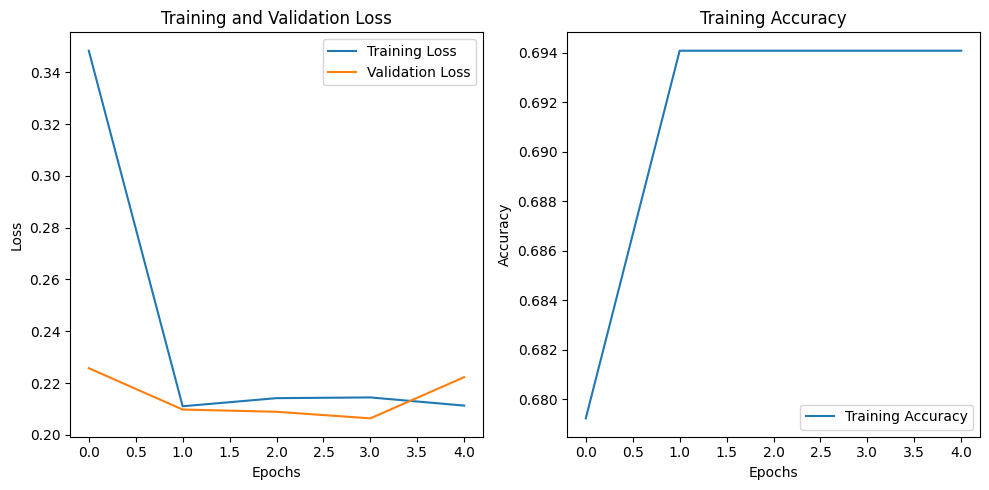

In [13]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score
import numpy as np

# Define test dataset and dataloader
test_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform)  # Use 'val' for testing
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=custom_collate)

model.eval()
all_predictions = []
all_masks = []

with torch.no_grad():
    for images, masks in test_loader:
        outputs = model(images)
        outputs = interpolate(outputs, size=(224, 224), mode='bilinear', align_corners=True)  # Ensure output size matches target
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.append(predicted.squeeze().cpu().numpy())
        all_masks.append(masks.squeeze().cpu().numpy())



Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

# Convert lists to NumPy arrays
all_predictions = np.array(all_predictions)
all_masks = np.array(all_masks)

# Ensure predictions and masks are integers for evaluation
all_predictions = all_predictions.astype(np.int64)
all_masks = all_masks.astype(np.int64)

# Calculate evaluation metrics
pixel_accuracy = accuracy_score(all_masks.flatten(), all_predictions.flatten())
mean_iou = jaccard_score(all_masks.flatten(), all_predictions.flatten(), average='macro')
f1 = f1_score(all_masks.flatten(), all_predictions.flatten(), average='macro')

print(f'Pixel Accuracy: {pixel_accuracy:.4f}')
print(f'Mean IoU: {mean_iou:.4f}')
print(f'F1 Score: {f1:.4f}')


Pixel Accuracy: 0.0275
Mean IoU: 0.0028
F1 Score: 0.0053
